# Scene classification

In [1]:
import os
os.listdir('../input/')

['intel-data-scene', 'places-resnet']

**Import the libraries**

In [2]:
!pip install pretrainedmodels

from torchvision.models import *
import pretrainedmodels

from fastai import *
from fastai.vision import *
from fastai.vision.models import *
from fastai.vision.learner import model_meta
import fastai

from utils import *
import sys
import torch

    100% |████████████████████████████████| 61kB 2.9MB/s 
  Stored in directory: /tmp/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built pretrainedmodels


In [3]:
path = "../input/intel-data-scene/scene_classification/scene_classification/train/"

In [4]:
fastai.__version__

'1.0.50.post1'

In [5]:
bs = 8

In [6]:
df = pd.read_csv('../input/intel-data-scene/scene_classification/scene_classification/train.csv')
df.head()

,image_name,label
0,0.jpg,0
1,1.jpg,4
2,2.jpg,5
3,4.jpg,0
4,7.jpg,4


In [7]:
import os
filenames = os.listdir('../input/intel-data-scene/scene_classification/scene_classification/test/')

In [8]:
tfms = get_transforms(flip_vert=False,max_zoom=1.0,do_flip=False,max_lighting=0.8,xtra_tfms=[cutout()])
data = (ImageList.from_csv(path, csv_name = '../train.csv') 
        .split_by_rand_pct()              
        .label_from_df()            
        .add_test_folder(test_folder = '../test')              
        .transform(tfms,size=150)
        .databunch(num_workers=0))

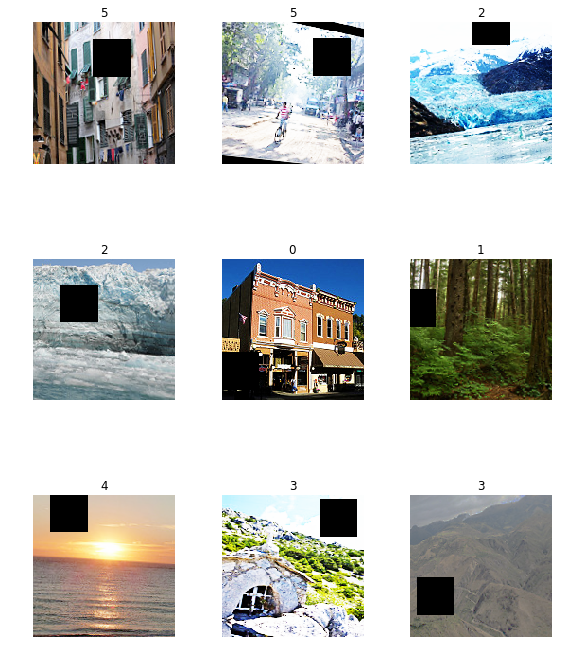

In [9]:
data.show_batch(rows=3, figsize=(8,10))

In [10]:
print(data.classes)

[0, 1, 2, 3, 4, 5]


## Places365 Model

In [11]:
def inceptionresnetv11( pretrained=True):
    pretrained = 'imagenet' if pretrained else None
    arch = 'resnet18'
    model_file = '%s_places365.pth.tar' % arch
    if not os.access(model_file, os.W_OK):
        weight_url = 'http://places2.csail.mit.edu/models_places365/' + model_file
        os.system('wget ' + weight_url)

    model = models.__dict__[arch](num_classes=365)
    checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
    state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
    model.load_state_dict(state_dict)
    return nn.Sequential(*model.children())

learn1 = create_cnn(data, inceptionresnetv11, pretrained=True, metrics=[error_rate, accuracy], model_dir="/tmp/model/",
                   cut=-2, split_on=lambda m: (m[0][6], m[1]))

def inceptionresnetv12( pretrained=True):
    pretrained = 'imagenet' if pretrained else None
    arch = 'resnet50'
    model_file = '%s_places365.pth.tar' % arch
    if not os.access(model_file, os.W_OK):
        weight_url = 'http://places2.csail.mit.edu/models_places365/' + model_file
        os.system('wget ' + weight_url)
    model = models.__dict__[arch](num_classes=365)
    checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
    state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
    model.load_state_dict(state_dict)
    return nn.Sequential(*model.children())

learn2 = create_cnn(data, inceptionresnetv12, pretrained=True, metrics=[error_rate, accuracy], model_dir="/tmp/model/",
                   cut=-2, split_on=lambda m: (m[0][6], m[1]))

def inceptionresnetv13( pretrained=True):
    pretrained = 'imagenet' if pretrained else None
#     model = pretrainedmodels.resnet18(pretrained=pretrained)
    arch = 'alexnet'
    model_file = '%s_places365.pth.tar' % arch
    if not os.access(model_file, os.W_OK):
        weight_url = 'http://places2.csail.mit.edu/models_places365/' + model_file
        os.system('wget ' + weight_url)
    model = models.__dict__[arch](num_classes=365)
    checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
    state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
    model.load_state_dict(state_dict)
    return nn.Sequential(*model.children())

learn3 = create_cnn(data, inceptionresnetv13, pretrained=True, metrics=[error_rate, accuracy], model_dir="/tmp/model/",
                   cut=-2, split_on=lambda m: (m[0][0][6], m[1]))


/opt/conda/lib/python3.6/site-packages/fastai/vision/learner.py:105: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


In [12]:
learn1.fit_one_cycle(6) 
learn1.unfreeze()
learn1.lr_find()
learn1.fit_one_cycle(6, max_lr=slice(1e-6,1e-4)) 

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.536626,0.243359,0.086318,0.913682,01:55
1,0.397379,0.256799,0.093658,0.906342,01:22
2,0.334705,0.215740,0.074868,0.925132,01:21
3,0.310884,0.195243,0.069289,0.930710,01:18
4,0.292529,0.193490,0.069289,0.930710,01:19
5,0.287987,0.193115,0.069289,0.930710,01:18


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.293837,0.189150,0.066060,0.933940,01:22
1,0.259020,0.188267,0.066060,0.933940,01:22
2,0.253724,0.182210,0.064885,0.935115,01:23
3,0.244184,0.180895,0.064005,0.935995,01:24
4,0.230295,0.178997,0.064005,0.935995,01:23
5,0.226096,0.179519,0.063711,0.936289,01:23


In [13]:
learn2.fit_one_cycle(6) 
learn2.unfreeze()
learn2.lr_find()
learn2.fit_one_cycle(6, max_lr=slice(1e-6,1e-4)) 

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.416647,0.213655,0.074868,0.925132,01:41
1,0.329321,0.214774,0.076336,0.923664,01:37
2,0.266267,0.181624,0.061656,0.938344,01:37
3,0.254811,0.176997,0.062830,0.937170,01:37
4,0.219837,0.173966,0.061950,0.938051,01:39
5,0.221746,0.168036,0.060482,0.939519,01:38


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.205537,0.165977,0.061362,0.938638,01:52
1,0.205784,0.164160,0.059307,0.940693,01:48
2,0.188174,0.162788,0.059307,0.940693,01:49
3,0.190489,0.161767,0.057546,0.942455,01:50
4,0.185820,0.161206,0.056958,0.943042,01:47
5,0.169542,0.160379,0.056078,0.943922,01:48


In [14]:
learn3.fit_one_cycle(3) 
learn3.unfreeze()
learn3.lr_find()
learn3.fit_one_cycle(6, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.823166,0.434924,0.156782,0.843218,01:12
1,0.688160,0.387759,0.135349,0.864651,01:11
2,0.641914,0.379175,0.134469,0.865531,01:10


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.623203,0.362901,0.127129,0.872871,01:11
1,0.614056,0.351283,0.124193,0.875807,01:16
2,0.573058,0.333459,0.114210,0.885790,01:11
3,0.534322,0.333013,0.114797,0.885203,01:12
4,0.557526,0.326734,0.114504,0.885496,01:12
5,0.540110,0.326613,0.113917,0.886083,01:12


In [15]:
preds1,_ = learn1.TTA(ds_type=DatasetType.Test)
preds2,_ = learn2.TTA(ds_type=DatasetType.Test)
preds3,_ = learn3.TTA(ds_type=DatasetType.Test)

pred1 = preds1 + preds2 + preds3
# pred1 = preds2

labelled_preds = []
for pred in pred1:
    labelled_preds.append(int(np.argmax(pred)))

submission = pd.DataFrame(
    {'image_name': filenames,
     'label': labelled_preds,
    })
submission.to_csv('new_submission1.csv',index=False)

In [16]:
torch.save(preds1,'resnet18_places')
torch.save(preds2,'resnet50_places')
torch.save(preds3,'Alexnet_places')

In [17]:
from IPython.display import HTML
import pandas as pd
import numpy as np
import base64

# download it (will only work for files < 2MB or so)
def create_download_link(df, title = "Download CSV file", filename = "tensor.csv"):  
    csv = df.to_csv(index=False)
    c = np.savetxt('foo.csv', pre, delimiter =', ')
    awe = pd.read_csv('foo.csv')
    csv = awe.to_csv(index=False)
    b64 = base64.b64encode(csv.encode())
#     b64 = np.encode(pre, encoding ='utf8')
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=b64,title=title,filename=filename)
    return HTML(html)

create_download_link(submission)

NameError: name 'pre' is not defined

In [18]:
del learn1
del learn2
del learn3
torch.cuda.empty_cache()

## Cadene & pretrained Pytorch Model

In [19]:
def resnext101_32x4d(pretrained=True):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.se_resnext101_32x4d(pretrained=pretrained)
    all_layers = list(model.children())
    return nn.Sequential(*all_layers[0], *all_layers[1:])
learn11 = create_cnn(data, resnext101_32x4d, pretrained=True, metrics=[error_rate, accuracy], model_dir="/tmp/model/",
                   cut=-2, split_on=lambda m: (m[0][6], m[1]))

learn11.fit_one_cycle(6) 
learn11.unfreeze()
learn11.lr_find()
learn11.fit_one_cycle(6, max_lr=slice(1e-6,1e-4))

/opt/conda/lib/python3.6/site-packages/fastai/vision/learner.py:105: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/se_resnext101_32x4d-3b2fe3d8.pth" to /tmp/.torch/models/se_resnext101_32x4d-3b2fe3d8.pth
196466866it [00:07, 24614958.57it/s]


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.606101,0.372897,0.139460,0.860540,02:46
1,0.481830,0.327381,0.125367,0.874633,02:43
2,0.414073,0.285342,0.103641,0.896359,02:42
3,0.368054,0.254481,0.096301,0.903699,02:43
4,0.337727,0.249787,0.090722,0.909278,02:43
5,0.332700,0.243339,0.090429,0.909571,02:43


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.317493,0.236595,0.090429,0.909571,03:18
1,0.293483,0.222611,0.083676,0.916324,03:19
2,0.267268,0.213203,0.080153,0.919847,03:19
3,0.239316,0.205374,0.075749,0.924251,03:17
4,0.238499,0.202200,0.073987,0.926013,03:18
5,0.230391,0.201211,0.072813,0.927187,03:17


In [20]:
def inceptionresnetv2(pretrained=True):
    pretrained = 'imagenet' if pretrained else None
    model11 = pretrainedmodels.inceptionresnetv2(pretrained=pretrained)
    return nn.Sequential(*model11.children())

learn12 = create_cnn(data, inceptionresnetv2, pretrained=True, metrics=[error_rate, accuracy], model_dir="/tmp/model/",
                   cut=-2, split_on=lambda m: (m[0][9], m[1]))

learn12.fit_one_cycle(6) 
learn12.unfreeze()
learn12.lr_find()
learn12.fit_one_cycle(6, max_lr=slice(1e-6,1e-4))

/opt/conda/lib/python3.6/site-packages/fastai/vision/learner.py:105: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/inceptionresnetv2-520b38e4.pth" to /tmp/.torch/models/inceptionresnetv2-520b38e4.pth
223774246it [00:09, 24824918.45it/s]


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.885005,0.582998,0.209630,0.790370,02:01
1,0.706465,0.520068,0.188491,0.811509,02:01
2,0.605650,0.453904,0.165590,0.834410,01:59
3,0.531969,0.405011,0.152672,0.847328,02:01
4,0.508021,0.353853,0.131239,0.868761,01:59
5,0.469791,0.345413,0.127716,0.872284,02:00


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.465340,0.333548,0.124780,0.875220,02:21
1,0.415165,0.288149,0.105989,0.894011,02:22
2,0.372620,0.256264,0.094245,0.905755,02:22
3,0.336901,0.249568,0.090722,0.909278,02:21
4,0.317075,0.248944,0.089254,0.910746,02:22
5,0.300295,0.243943,0.087786,0.912214,02:21


In [21]:
learn13 = cnn_learner(data, models.densenet201, metrics=[error_rate, accuracy], model_dir="/tmp/model/")

learn14 = cnn_learner(data, models.resnet152, metrics=[error_rate, accuracy], model_dir="/tmp/model/")

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /tmp/.torch/models/densenet201-c1103571.pth
81131730it [00:01, 78348649.21it/s]
Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /tmp/.torch/models/resnet152-b121ed2d.pth
241530880it [00:04, 59798063.08it/s]


In [22]:
learn13.lr_find()
learn13.fit_one_cycle(6, max_lr=slice(1e-6,1e-4)) 
learn13.unfreeze()
learn13.lr_find()
learn13.fit_one_cycle(6, max_lr=slice(1e-6,1e-4))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.154564,0.554920,0.186436,0.813564,02:04
1,0.550145,0.306871,0.107164,0.892836,02:03
2,0.447722,0.265465,0.090135,0.909865,02:02
3,0.399113,0.255952,0.089254,0.910746,02:02
4,0.391423,0.251999,0.086612,0.913388,02:03
5,0.383682,0.250740,0.087786,0.912214,02:02


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.393126,0.239506,0.081914,0.918086,02:18
1,0.333623,0.223113,0.075161,0.924839,02:19
2,0.310369,0.213401,0.072813,0.927187,02:18
3,0.283656,0.204390,0.070757,0.929242,02:19
4,0.273522,0.200410,0.067821,0.932178,02:17
5,0.269434,0.205033,0.071345,0.928655,02:20


In [23]:
learn14.lr_find()
learn14.fit_one_cycle(6, max_lr=slice(1e-6,1e-4)) 
learn14.unfreeze()
learn14.lr_find()
learn14.fit_one_cycle(6, max_lr=slice(1e-6,1e-4))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.179995,0.536865,0.168526,0.831474,02:18
1,0.621258,0.336181,0.117440,0.882560,02:19
2,0.511159,0.303375,0.108632,0.891368,02:18
3,0.471287,0.285837,0.101292,0.898708,02:19
4,0.460721,0.276613,0.096594,0.903406,02:19
5,0.465572,0.276386,0.098062,0.901938,02:19


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.434846,0.259911,0.093365,0.906635,02:42
1,0.355920,0.218907,0.077804,0.922196,02:44
2,0.291541,0.204952,0.078097,0.921903,02:44
3,0.265545,0.197854,0.070464,0.929536,02:46
4,0.248176,0.196753,0.070464,0.929536,02:44
5,0.239915,0.195148,0.070170,0.929830,02:44


In [24]:
preds11,_ = learn11.TTA(ds_type=DatasetType.Test)
preds12,_ = learn12.TTA(ds_type=DatasetType.Test)
preds13,_ = learn13.TTA(ds_type=DatasetType.Test)
preds14,_ = learn14.TTA(ds_type=DatasetType.Test)
# preds3,_ = learn3.TTA(ds_type=DatasetType.Test)

pred1 = preds11 + preds12 + preds13 + preds14

labelled_preds = []
for pred in pred1:
    labelled_preds.append(int(np.argmax(pred)))

submission = pd.DataFrame(
    {'image_name': filenames,
     'label': labelled_preds,
    })
submission.to_csv('new_submission11.csv',index=False)

In [25]:
torch.save(preds11,'resnext_imagenet')
torch.save(preds12,'inceptionresnet_imagenet')
torch.save(preds13,'densenet201_imagenet')
torch.save(preds14,'resnet152_imagenet')

In [26]:
del learn11
del learn12
del learn13
del learn14
torch.cuda.empty_cache()

In [27]:
from IPython.display import HTML
import pandas as pd
import numpy as np
import base64

# download it (will only work for files < 2MB or so)
def create_download_link(df, title = "Download CSV file", filename = "subm.csv"):  
    csv = df.to_csv(index=False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

create_download_link(submission)

**Changing image resolution to 256**

In [28]:
tfms = get_transforms(flip_vert=False,max_zoom=1.0,max_warp=0)
data = (ImageList.from_csv(path, csv_name = '../train.csv') 
        .split_by_rand_pct()              
        .label_from_df()            
        .add_test_folder(test_folder = '../test')              
        .transform( size=256)
        .databunch(num_workers=0))

In [29]:
def inceptionresnetv14( pretrained=True):
    pretrained = 'imagenet' if pretrained else None
    arch = 'resnet18'
    model_file = '%s_places365.pth.tar' % arch
    if not os.access(model_file, os.W_OK):
        weight_url = 'http://places2.csail.mit.edu/models_places365/' + model_file
        os.system('wget ' + weight_url)

    model = models.__dict__[arch](num_classes=365)
    checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
    state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
    model.load_state_dict(state_dict)
    return nn.Sequential(*model.children())

learn4 = create_cnn(data, inceptionresnetv14, pretrained=True, metrics=[error_rate, accuracy], model_dir="/tmp/model/",
                   cut=-2, split_on=lambda m: (m[0][6], m[1]))

def inceptionresnetv15( pretrained=True):
    pretrained = 'imagenet' if pretrained else None
    arch = 'resnet50'
    model_file = '%s_places365.pth.tar' % arch
    if not os.access(model_file, os.W_OK):
        weight_url = 'http://places2.csail.mit.edu/models_places365/' + model_file
        os.system('wget ' + weight_url)
    model = models.__dict__[arch](num_classes=365)
    checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
    state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
    model.load_state_dict(state_dict)
    return nn.Sequential(*model.children())

learn5 = create_cnn(data, inceptionresnetv15, pretrained=True, metrics=[error_rate, accuracy], model_dir="/tmp/model/",
                   cut=-2, split_on=lambda m: (m[0][6], m[1]))

# def inceptionresnetv16( pretrained=True):
#     pretrained = 'imagenet' if pretrained else None
# #     model = pretrainedmodels.resnet18(pretrained=pretrained)
#     arch = 'alexnet'
#     model_file = '%s_places365.pth.tar' % arch
#     if not os.access(model_file, os.W_OK):
#         weight_url = 'http://places2.csail.mit.edu/models_places365/' + model_file
#         os.system('wget ' + weight_url)
#     model = models.__dict__[arch](num_classes=365)
#     checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
#     state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
#     model.load_state_dict(state_dict)
#     return nn.Sequential(*model.children())

# learn6 = create_cnn(data, inceptionresnetv16, pretrained=True, metrics=[error_rate, accuracy], model_dir="/tmp/model/",
#                    cut=-2, split_on=lambda m: (m[0][0][6], m[1]))

/opt/conda/lib/python3.6/site-packages/fastai/vision/learner.py:105: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


In [30]:
learn4.fit_one_cycle(3) 
learn4.unfreeze()
learn4.lr_find()
learn4.fit_one_cycle(6, max_lr=slice(1e-6,1e-4)) 

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.275680,0.179488,0.067821,0.932178,01:44
1,0.215166,0.164468,0.060482,0.939519,01:43
2,0.168585,0.154913,0.057839,0.942161,01:44


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.156378,0.150408,0.054903,0.945097,01:51
1,0.152422,0.150364,0.054903,0.945097,01:52
2,0.119581,0.151041,0.053729,0.946271,01:53
3,0.088681,0.151799,0.054022,0.945978,01:52
4,0.081659,0.149543,0.054022,0.945978,01:53
5,0.073958,0.150738,0.053435,0.946565,01:53


In [31]:
learn5.fit_one_cycle(3) 
learn5.unfreeze()
learn5.lr_find()
learn5.fit_one_cycle(6, max_lr=slice(1e-6,1e-4)) 

# learn6.fit_one_cycle(3) 
# learn6.unfreeze()
# learn6.lr_find()
# learn6.fit_one_cycle(6, max_lr=slice(1e-6,1e-4)) 

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.254573,0.175568,0.063711,0.936289,02:35
1,0.176371,0.158778,0.058426,0.941574,02:33
2,0.131094,0.154619,0.055490,0.944510,02:31


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.111032,0.153929,0.054903,0.945097,02:55
1,0.102311,0.153730,0.055784,0.944216,02:56
2,0.072051,0.162815,0.053435,0.946565,02:55
3,0.047527,0.169742,0.051967,0.948033,02:55
4,0.031898,0.170679,0.049618,0.950382,02:55
5,0.028026,0.173758,0.053729,0.946271,02:56


In [32]:
preds4,_ = learn4.TTA(ds_type=DatasetType.Test)
preds5,_ = learn5.TTA(ds_type=DatasetType.Test)
# preds6,_ = learn6.TTA(ds_type=DatasetType.Test)

pred1 = preds4 + preds5

labelled_preds = []
for pred in pred1:
    labelled_preds.append(int(np.argmax(pred)))

submission = pd.DataFrame(
    {'image_name': filenames,
     'label': labelled_preds,
    })
submission.to_csv('new_submission2.csv',index=False)

TypeError: 'NoneType' object is not iterable

In [33]:
torch.save(preds4,'resnet18_places_256')
torch.save(preds5,'resnet50_places_256')

NameError: name 'preds4' is not defined

In [34]:
del learn4
del learn5
torch.cuda.empty_cache()

In [35]:
learn23 = cnn_learner(data, models.densenet201, metrics=[error_rate, accuracy], model_dir="/tmp/model/")

learn24 = cnn_learner(data, models.resnet152, metrics=[error_rate, accuracy], model_dir="/tmp/model/")

In [36]:
learn23.lr_find()
learn23.fit_one_cycle(6, max_lr=slice(1e-6,1e-4)) 
learn23.unfreeze()
learn23.lr_find()
learn23.fit_one_cycle(6, max_lr=slice(1e-6,1e-4))

RuntimeError: CUDA out of memory. Tried to allocate 1024.00 KiB (GPU 0; 15.90 GiB total capacity; 15.25 GiB already allocated; 1.88 MiB free; 11.52 MiB cached)

In [37]:
learn24.lr_find()
learn24.fit_one_cycle(6, max_lr=slice(1e-6,1e-4)) 
learn24.unfreeze()
learn24.lr_find()
learn24.fit_one_cycle(6, max_lr=slice(1e-6,1e-4))

RuntimeError: CUDA out of memory. Tried to allocate 1024.00 KiB (GPU 0; 15.90 GiB total capacity; 15.25 GiB already allocated; 1.88 MiB free; 10.51 MiB cached)

In [38]:
preds23,_ = learn23.TTA(ds_type=DatasetType.Test)
preds24,_ = learn24.TTA(ds_type=DatasetType.Test)
# preds3,_ = learn3.TTA(ds_type=DatasetType.Test)

pred1 = preds23 + pred24

labelled_preds = []
for pred in pred1:
    labelled_preds.append(int(np.argmax(pred)))

submission = pd.DataFrame(
    {'image_name': filenames,
     'label': labelled_preds,
    })
submission.to_csv('new_submission21.csv',index=False)

RuntimeError: CUDA out of memory. Tried to allocate 48.00 MiB (GPU 0; 15.90 GiB total capacity; 15.25 GiB already allocated; 1.88 MiB free; 10.51 MiB cached)

In [39]:
torch.save(preds23,'densenet201_places_256')
torch.save(preds24,'resnet152_places_256')

NameError: name 'preds23' is not defined

In [40]:
pred1 = preds11 + preds12 + preds13 + preds14 + preds23 + pred24

labelled_preds = []
for pred in pred1:
    labelled_preds.append(int(np.argmax(pred)))

submission = pd.DataFrame(
    {'image_name': filenames,
     'label': labelled_preds,
    })
submission.to_csv('new_submission21_all.csv',index=False)

NameError: name 'preds23' is not defined

In [41]:
del learn23
del learn24

In [42]:
# learn4.save('learn4/stage4')
# learn5.save('learn5/stage5')
# learn6.save('learn6/stage6')

In [43]:
pred1 = preds1 + preds2 + preds4 + preds5

labelled_preds = []
for pred in pred1:
    labelled_preds.append(int(np.argmax(pred)))

submission = pd.DataFrame(
    {'image_name': filenames,
     'label': labelled_preds,
    })
submission.to_csv('new_submission3.csv',index=False)

NameError: name 'preds4' is not defined

In [44]:
pred1 =  preds1 + preds4

labelled_preds = []
for pred in pred1:
    labelled_preds.append(int(np.argmax(pred)))

submission = pd.DataFrame(
    {'image_name': filenames,
     'label': labelled_preds,
    })
submission.to_csv('new_submission4.csv',index=False)

NameError: name 'preds4' is not defined

In [45]:
pred1 =  preds2 + preds5

labelled_preds = []
for pred in pred1:
    labelled_preds.append(int(np.argmax(pred)))

submission = pd.DataFrame(
    {'image_name': filenames,
     'label': labelled_preds,
    })
submission.to_csv('new_submission5.csv',index=False)

NameError: name 'preds5' is not defined

In [46]:
model11 = pretrainedmodels.inceptionresnetv2(pretrained='imagenet')
aa = nn.Sequential(*model11.children())

In [47]:
pred1 = preds11 + preds12 + preds13 + preds14 + preds23 + pred24 + preds1 + preds2 + preds4 + preds5

labelled_preds = []
for pred in pred1:
    labelled_preds.append(int(np.argmax(pred)))

submission = pd.DataFrame(
    {'image_name': filenames,
     'label': labelled_preds,
    })
submission.to_csv('submission_all.csv',index=False)

NameError: name 'preds23' is not defined